In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
!ls "/content/drive/My Drive/News"

Fake.csv  True.csv


In [ ]:
real = pd.read_csv("/content/drive/My Drive/News/True.csv")
fake = pd.read_csv("/content/drive/My Drive/News/Fake.csv")

In [ ]:
#Displayed the first 5 rows of the real news dataset
real.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [ ]:
#Displayed the first 5 rows of the fake news dataset
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [ ]:
#Shape of real news dataset
print("Real news: ",real.shape)
#Shape of fake news dataset
print("Fake News: ", fake.shape)

Real news:  (21417, 4)
Fake News:  (23481, 4)


In [ ]:
#Assigning a value of 0 for all real news data and placing it in the dataframe
class0 = []

for i in range(21417):
  class0.append(0)

real.insert(4, "class", class0, True)

In [ ]:
#Assigning a value of 1 for all fake news data and placing it in the dataframe
class1 = []

for i in range(23481):
  class1.append(1)

fake.insert(4, "class", class1, True)

In [ ]:
#Concactenating fake news and real news into 1 total dataset
total = pd.concat([real,fake])
total = total.sample(frac = 1)

In [ ]:
#Shape of total
total.shape

(44898, 5)

In [ ]:
#total = total.sample(frac=1)
pd.set_option('display.width', total.shape[0])
total.head()


,title,text,subject,date,class
13640,RACIST OBAMA BASHES WHITEY As The “Old Boys Ne...,OH MY GOSH! Obama bashes the old boys network...,politics,"Jun 24, 2016",1
16499,U.N. nuclear chief to visit Iran this weekend,VIENNA (Reuters) - The head of the United Nati...,worldnews,"October 25, 2017",0
14653,DID IRAN RELEASE This Footage Of Captured U.S....,And what about the female sailor in the headsc...,politics,"Jan 14, 2016",1
8035,Clinton server tech told FBI of colleagues' wo...,NEW YORK (Reuters) - A technician hired by Hil...,politicsNews,"September 24, 2016",0
9540,NANCY PELOSI Has Awkward Brain Freeze When Ask...,"Yes, another brain freeze moment from Nancy Pe...",politics,"Nov 1, 2017",1


In [ ]:
#Extract only the values for title (input) and class (output)
data = total[['title','class']]
data.head()


,title,class
13640,RACIST OBAMA BASHES WHITEY As The “Old Boys Ne...,1
16499,U.N. nuclear chief to visit Iran this weekend,0
14653,DID IRAN RELEASE This Footage Of Captured U.S....,1
8035,Clinton server tech told FBI of colleagues' wo...,0
9540,NANCY PELOSI Has Awkward Brain Freeze When Ask...,1


In [ ]:
# Character Length of Titles - Min, Mean, Max
print('Mean Length', data['title'].apply(len).mean())
print('Min Length', data['title'].apply(len).min())
print('Max Length', data['title'].apply(len).max())



Mean Length 80.11171989843646
Min Length 8
Max Length 286


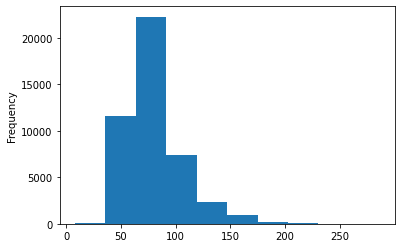

In [ ]:
#plotting the frequency of characters on a histogram
import seaborn as sns

x = data['title'].apply(len).plot.hist()

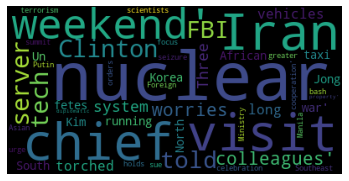

In [ ]:
#Word cloud of most common words from real news 
#For fake news, change ["class"] == 0 to 1
from wordcloud import WordCloud, STOPWORDS

#Note to self: fix for entire dataset
text = data[data["class"] == 0].values
wc = WordCloud(stopwords=STOPWORDS).generate(str(text))
plt.imshow(wc)
plt.axis("off")
plt.show()

In [ ]:
#Extracting numpy arrays for the title and classes
titles = data["title"].values
labels = data["class"].values



In [ ]:
from sklearn.model_selection import train_test_split

#Split data into training and testing dataset
#We teach our model based on the training set (including the labels)
#We take the labels away to test our model with the testing set
title_train, title_test, y_train, y_test = train_test_split(titles, labels, test_size=0.2, random_state=1000)



In [ ]:
!pip install tensorflow-text
import tensorflow_hub as hub
import tensorflow_text as text

     |████████████████████████████████| 4.9 MB 5.3 MB/s 


In [ ]:
#Download bert preprocesser and bert encoder from tensorflow_hub
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4')

In [ ]:
def embed(headlines):
  processed = bert_preprocess(headlines)
  return bert_encoder(processed)['pooled_output']



In [ ]:
import tensorflow as tf

# Input Layers
input_layer = tf.keras.layers.Input(shape=(), dtype=tf.string, name='news')

# BERT layers
processed = bert_preprocess(input_layer)
output = bert_encoder(processed)

# Neural Network Layers

layer = tf.keras.layers.Dropout(0.2, name='dropout')(output['pooled_output'])
layer = tf.keras.layers.Dense(10,activation='relu', name='hidden')(layer)
layer = tf.keras.layers.Dense(1,activation='sigmoid', name='output')(layer)


model = tf.keras.Model(inputs=[input_layer],outputs=[layer])


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 news (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['news[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [ ]:
#Compile model on adam optimizer, binary_crossentropy loss, and accuracy metrics
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
#Train model on 5 epochs
model.fit(title_train,y_train,epochs=5)

Epoch 1/5
1123/1123 [==============================] - 842s 729ms/step - loss: 0.3628 - accuracy: 0.8401
Epoch 2/5
1123/1123 [==============================] - 817s 727ms/step - loss: 0.2847 - accuracy: 0.8829
Epoch 3/5
1123/1123 [==============================] - 817s 727ms/step - loss: 0.2734 - accuracy: 0.8860
Epoch 4/5
1123/1123 [==============================] - 816s 727ms/step - loss: 0.2718 - accuracy: 0.8865
Epoch 5/5
1123/1123 [==============================] - 817s 728ms/step - loss: 0.2696 - accuracy: 0.8886


In [ ]:
#Evaluate model on test data
model.evaluate(title_test,y_test)

281/281 [==============================] - 205s 726ms/step - loss: 0.2241 - accuracy: 0.9114


[0.22406823933124542, 0.9113585948944092]

In [ ]:
#Download model with pickle
import pickle 

pickle.dump(model, open('bert.pkl','wb'))


INFO:tensorflow:Assets written to: ram://3ff51c16-225f-448e-a63e-a1548f70d3b3/assets


INFO:tensorflow:Assets written to: ram://3ff51c16-225f-448e-a63e-a1548f70d3b3/assets
